# **Next actions and TODOs**


In this notebook I introduce that we drop rescaling in Z-axis (but the distances will get screwed up and need to be rescaled).

Also, frustrated by "branch jumping", I decided to take another go at iterative building of paths, from large sigmas to smaller ones. It did take a hell lot of a time, but now it seems to work (well, at least performs better than building the paths at one go).

 - [ ] Test performance on other cells
 - [ ] Test performace of the approach with more sigma steps (log scale is preferred, i.e. `2.0**np.arange(-1,5,0.5)`)
 - [ ] Think about a way to regularize vector orientations, using orientations of the neighbours, or at different scales
 - [-] Find a best way to skeletonize the qstack-based arrays and masks (as one of the approaches)
 - [X] Find a way to "glue" together paths, that a close-by and have a similar direction
 - [ ] Visualize different sub-trees in the merged paths (add individually to napari?)
 - [ ] add way to gradually strip/simplify (sub-)graphs for better visualization
 

In [2]:
import os
import sys
import itertools as itt

# File reading
from pathlib import Path
import tifffile as tiff

# Image preprocessing
import cv2
from skimage.filters import threshold_li, threshold_minimum, threshold_triangle
from skimage.morphology import remove_small_objects


# Calculations
from scipy import ndimage as ndi
import numpy as np

# Analysis
import astrobject as ao
import ccdb
import astromorpho as astro
import networkx as nx

# Viewing
import napari
import matplotlib.pyplot as plt
%matplotlib inline
from networx2napari import draw_edges, draw_nodes

# Beauty
from tqdm.auto import tqdm

# Utils
from functools import reduce
import operator as op
from importlib import reload

Can't load imreg package, affine and homography registrations won't work


/home/incredible/Neuroscience/Code/lib/imfun/imfun/external/tifffile.py:7261: UserWarning: No module named 'imfun.external._tifffile'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))
/home/incredible/Neuroscience/Code/lib/imfun/imfun/external/czifile.py:146: UserWarning: ImportError: No module named '_czifile'. Decoding of JXR and JPEG encoded images will not be available. Czifile.pyx can be obtained at http://www.lfd.uci.edu/~gohlke/
  warnings.warn(


In [3]:
def eu_dist(p1, p2):
    return np.sqrt(np.sum([(x - y)**2 for x, y in zip(p1, p2)]))

In [4]:
def get_shell_mask(mask, do_skeletonize=False, as_points=False):
    out = ndi.binary_erosion(mask)^mask
    if do_skeletonize:
        out = skeletonize(out)
    if as_points:
        out = astro.morpho.mask2points(out)
    return out 

In [5]:
def largest_region(mask):
    labels, nlab = ndi.label(mask)
    if nlab > 0:
        objs = ndi.find_objects(labels)
        sizes = [np.sum(labels[o]==k+1) for k,o in enumerate(objs)]
        k = np.argmax(sizes)
        return labels==k+1
    else:
        return mask
        
def crop_image(img, mask=None, margin=0, min_obj_size=0):
    if mask is None:
        mask = img > 0
    if min_obj_size > 0:
        mask = remove_small_objects(mask, min_obj_size)
    if margin > 0:
        mask = ndi.binary_dilation(mask, iterations=margin)
    objs = ndi.find_objects(mask)
    min_bnds = np.min([[sl.start for sl in o] for o in objs],0)
    max_bnds = np.max([[sl.stop for sl in o] for o in objs],0)
    crop = tuple(slice(mn,mx) for mn,mx in zip(min_bnds, max_bnds))
    return img[crop]

In [6]:
plt.rc('figure', dpi=150)

# Параметры для запуска

In [7]:
if os.path.exists('/home/incredible/astro-morpho'):
    data_dir = '/home/incredible/astro-morpho/data/atlas/'
else:
    print("Dont know where to look for the data")

output_dir = './output/'

# filename = '28 Alzheimer Lynx1'
# filename = '11 Alzheimer'
file_dir = 'a22 tgL x20_2'
filename = 'a22 tgL x20_2/a22 tgL x20_2_z04.tif'
# filename = 'test_astro.tiff'


filetype = 'TIFF' # Can be 'TIFF'

imagetype = 'CROP' # Can be 'STACK' or 'CROP'

use_clahe = True
sigmas = 2**np.arange(0, 3, 0.5)
alpha = 0.5 # relative weight of coside distance between Hessian vector and linkage vector
beta = 0.0  # weight of Euclidean distance between the nodes 
offset=1

VERBOSE = True

# Set false to start from console
HANDY = True

# Set true to save output
OUT = False

# Считывание изображения

In [8]:
if HANDY:
    VERBOSE = False

In [9]:
datapath = Path(data_dir).joinpath(file_dir)
# datapath = Path(data_dir).joinpath(filename)
datapath

PosixPath('/home/incredible/astro-morpho/data/atlas/a22 tgL x20_2')

In [10]:
# x1, x2, y1, y2 = 1004, 1622, 2266, 2780 # 11 Alzheimer
# x1, x2, y1, y2 = 822, 1306, 2641, 3082 # 28 Alzheimer Lynx1
x1, x2, y1, y2 = 1231, 1634, 2138, 2486 # test_astrocyte

In [11]:
if imagetype == 'CROP':
    stack = np.zeros((23, x2-x1, y2-y1))
elif imagetype == 'STACK':
    stack = np.zeros((23, 4096, 4096))

filenames = [filename for filename in os.listdir(datapath)]
filenames = sorted(filenames)
for i, filename in enumerate(filenames):
    filepath = Path(datapath).joinpath(filename)
    if imagetype == 'CROP':
        stack[i] = tiff.imread(filepath)[x1:x2, y1:y2]
    elif imagetype == 'STACK':
        stack[i] = tiff.imread(filepath)[..., 2]

In [ ]:
stack = tiff.imread(datapath)
# image = np.zeros((2, *stack.shape))
# image[0]=stack
# image[1]=stack

In [ ]:
stack.shape

In [12]:
w = napari.view_image(stack)
# w.add_image(tiff.imread(filepath)[..., 2])

In [13]:
stack = stack[1:9]

# Выделение отдельных клеток

In [14]:
cell_choosing_viewer = napari.view_image(stack[6])

In [15]:
class Cell():
    def __init__(self, region=None, image=None):
        self.region = region
        self.image = image

In [ ]:
cell_choosing_viewer.layers[1].data

In [ ]:
cells = []
layer_name = '{}_cell_select.csv'.format(os.path.basename(filename))

if layer_name in :
    layer.save(os.path.join(output_dir, layer_name)) 


for layer in cell_choosing_viewer.layers:
    if type(layer) is napari.layers.shapes.shapes.Shapes:      
        for arr in layer.data:
            r = np.array([arr.min(axis=0), arr.max(axis=0)], dtype=int)
            cells.append(Cell(r, stack[:12, r[0][0]:r[1][0], r[0][1]:r[1][1]]))
            

In [ ]:
# w = napari.view_image(np.zeros((1,1,1)))
# for cell in cells:
#     print(cell.region, cell.image.shape)
#     w.add_image(cell.image)
    

# Анализ клеток

In [75]:
# cell = cells[0]
cell = Cell(image=final_image)

print('Center')
obj = ao.AstrObject(cell.image)
obj.center_detection()

Center


In [76]:
print('Soma Mask')
%time obj.soma_segmentation(return_shell=True)

Soma Mask
Mask Expanding
Soma Shell
CPU times: user 188 ms, sys: 0 ns, total: 188 ms
Wall time: 184 ms


In [77]:
if VERBOSE:
    w = napari.view_image(cell.image, ndisplay=3, opacity=0.5)
    w.add_image(obj.soma_mask, blending='additive', colormap='magenta')

In [78]:
print('Branch Segmentation')
%time obj.branch_segmentation((1,), sigmas=sigmas)

Branch Segmentation
Vectors and Masks...
Merging...
CPU times: user 12.6 s, sys: 69.8 ms, total: 12.7 s
Wall time: 12.7 s


In [79]:
if VERBOSE:
    w = napari.view_image(cell.image, ndisplay=3, opacity=0.5)
    w.add_image(obj.sigma_mask, blending='additive', colormap='turbo')

In [80]:
print('Full Graph')
%time obj.full_graph_plotting(alpha, beta)

Full Graph
CPU times: user 5.25 s, sys: 43.9 ms, total: 5.29 s
Wall time: 5.29 s


In [81]:
def draw_edges(pos, edgelist):
    return np.asarray([[pos[n1], pos[n2]] for n1, n2 in edgelist])
if VERBOSE:
    w = napari.view_image(cell.image, ndisplay=3, opacity=0.5)
    points = np.array([n for n in obj.full_graph.nodes])
    img_test = np.zeros(cell.image.shape)
    img_test[points[:,0], points[:,1], points[:,2]] = 1
    w.add_image(img_test, blending='additive')
    pos = {n:n for n in obj.full_graph.nodes}
    edges = draw_edges(pos, list(obj.full_graph.edges))
    w.add_shapes(edges[:1000], shape_type='line', edge_width=0.1)

In [82]:
print('Graph')
%time obj.astro_graph_plotting(min_path_length=10)
graph = obj.graph

Graph


  0%|          | 0/207 [00:00<?, ?it/s]

<class 'astro_graph.AstroGraph'>
No cycles!
CPU times: user 1min 44s, sys: 153 ms, total: 1min 44s
Wall time: 1min 44s


In [84]:
if VERBOSE:
    w =  napari.view_image(cell.image, ndisplay=3, opacity=0.5)
#     w.add_image(sigma_mask, colormap='turbo', blending='additive', visible=False)
    graph.view_graph_as_colored_image(cell.image.shape, w);
    napari.run()

Так как тестовый вариант, то сначала считаем для одной клетки

In [16]:
# image = cells[2].image
# napari.view_image(image)
image = stack

# Предобработка изображения

## CLAHE

In [17]:
clahe = cv2.createCLAHE(clipLimit =2.0, tileGridSize=(8,8))

In [18]:
stack_shape = image.shape
img_clahe = np.zeros(image.shape, np.float32)
for k, plane in enumerate(image):
    img_clahe[k] = clahe.apply(plane.astype('uint8'))

In [19]:
if VERBOSE:
    wi = napari.view_image(image, ndisplay=3, scale=(1, 1,1), name='raw', colormap='magenta')
    wi.add_image(img_clahe, scale=(1,1,1), name='CLAHE',colormap='magenta')

In [20]:
# check if use clahe or not
img = img_clahe # if use_clahe else stack

## Фильтрация изображения

In [ ]:
img_noisy = image /255
img_noisy.min(), img_noisy.max()

In [ ]:
from skimage.filters import threshold_minimum, threshold_local, threshold_yen, threshold_isodata, rank, threshold_otsu
from skimage.morphology import disk, ball

In [ ]:
def filter_image(image, filter_func):
    threshold = filter_func(image)
    #img_filt = np.where(image > threshold, image, 0)
    pre_mask = ndi.binary_closing(image >= threshold)
    pre_mask = remove_small_objects(pre_mask, 5, connectivity=3)
    binary_clean = largest_region(pre_mask)
    return np.where(binary_clean, image, 0), threshold

In [ ]:
img_li, li = filter_image(img_noisy, threshold_li)
img_min, m = filter_image(img_noisy, threshold_minimum)
img_iso, iso = filter_image(img_noisy, threshold_isodata)
img_yen, yen = filter_image(img_noisy, threshold_yen)
# img_loc, loc = filter_image(img_noisy, threshold_local)

In [ ]:
img_tr, tr = filter_image(img_noisy, threshold_triangle)
img_ots, ots = filter_image(img_noisy, threshold_otsu)

In [ ]:
plt.hist(np.ravel(img_noisy), bins=255)
plt.axvline(li, color='red', label='li')
plt.axvline(m, color='orange', label='min')
plt.axvline(iso, color='green', label='iso')
plt.axvline(yen, color='black', label='yen')
plt.axvline(ots, color='blue', label='otsu')
plt.axvline(tr, color='yellow', label='triangle')
plt.legend()
# plt.hist(np.ravel(img_clear), bins=255)
plt.show()

In [ ]:
w = napari.view_image(img_noisy)
w.add_image(img_li)
w.add_image(img_tr)
w.add_image(img_min)
w.add_image(img_iso)
w.add_image(img_yen)
w.add_image(img_ots)
w.add_image(img)

Лучше всего работает Yen, но Iso лучше

In [ ]:
final_image = image
final_image.shape

In [ ]:
domain_mask3d = ndi.binary_fill_holes(final_image > 0)
domain_shell_mask = get_shell_mask(domain_mask3d)

In [ ]:
def planewise_fill_holes(mask):
    for k,plane in enumerate(mask):
        mask[k] = ndi.binary_fill_holes(plane)
    return mask

    
domain_mask3d = planewise_fill_holes(domain_mask3d)

domain_mask3d = np.moveaxis(domain_mask3d, 1, 0)   
domain_mask3d = planewise_fill_holes(domain_mask3d)
domain_mask3d = np.moveaxis(domain_mask3d, 0, 1)


domain_mask3d = np.moveaxis(domain_mask3d, 2, 0)
domain_mask3d = planewise_fill_holes(domain_mask3d)
domain_mask3d = np.moveaxis(domain_mask3d, 0, 2)

In [ ]:
domain_outer_shell_mask = get_shell_mask(domain_mask3d) & domain_shell_mask

In [ ]:
if VERBOSE:
    w = napari.view_image(final_image)
#     w.add_image(final_image, colormap='magenta', blending='additive')
    w.add_image(domain_shell_mask, colormap='green', blending='additive')
    w.add_image(domain_outer_shell_mask, colormap='red', blending='additive')

In [ ]:
import skeletonization as skelet

In [ ]:
from importlib import reload
reload(skelet)

# Сегментация сомы

In [28]:
from skimage.morphology import flood

In [29]:
def percentile_rescale(arr, plow=1, phigh=99.5):
    low, high = np.percentile(arr, (plow, phigh))
    if low == high:
        return np.zeros_like(arr)
    else:
        return np.clip((arr-low)/(high-low), 0, 1)


def flat_indices(shape):
    idx = np.indices(shape)
    return np.hstack([np.ravel(x_)[:,None] for x_ in idx])


In [30]:
X1a = flat_indices(final_image.shape)
weights_s = percentile_rescale(np.ravel(ndi.gaussian_filter(final_image,5))**2,plow=99.5,phigh=99.99)
center = tuple(map(int, np.sum(X1a*weights_s[:,None],axis=0)/np.sum(weights_s)))

In [ ]:
smooth_stack = ndi.gaussian_filter(final_image, 3)
tol = (smooth_stack.max() - smooth_stack[image>0].min())/10
soma_seed_mask = flood(smooth_stack, center, tolerance=tol)

In [ ]:
w = napari.view_image(final_image, opacity=0.5)
w.add_image(soma_seed_mask, colormap='magenta', blending='additive')

In [ ]:
soma_mask = astro.morpho.expand_mask(soma_seed_mask, smooth_stack, iterations=10)

In [ ]:
soma_shell = get_shell_mask(soma_mask, as_points=True)

In [ ]:
np.array([np.array(center)])

In [ ]:
w = napari.view_image(final_image)
w.add_image(soma_seed_mask)
w.add_image(soma_mask)
w.add_points(data=np.array(center))
# w.add_image(soma_shell)

# Ручное выделение клетки

In [22]:
final_image = img

In [23]:
region_choosing = napari.view_image(final_image)
napari.run()

In [24]:
idx = region_choosing.layers[1].data[0].astype(int)

In [25]:
from skimage.draw import polygon, polygon2mask, polygon_perimeter
mask = np.zeros(final_image.shape, dtype=bool)
rr, cc = polygon(idx[:,1], idx[:,2], final_image.shape[1:])
mask[4, rr, cc] = 1

In [31]:
# flats = np.array([(i, r, c) for i in range(final_image.shape[0]) for r,c in zip(rr, cc)])
flats = np.array([(4, r, c) for r,c in zip(rr, cc)])
weights_s = percentile_rescale(np.ravel(ndi.gaussian_filter(final_image[mask],5))**2,plow=99.5,phigh=99.99)
center = tuple(map(int, np.sum(flats*weights_s[:,None],axis=0)/np.sum(weights_s)))

In [32]:
center

(3, 223, 188)

In [33]:
test_mask = mask[:]
test_mask[:, rr, cc] = 1
img[~test_mask] = 0
napari.view_image(img)

Viewer(axes=Axes(visible=False, labels=True, colored=True, dashed=False, arrows=True), camera=Camera(center=(0.0, 201.0, 173.5), zoom=1.713771712158809, angles=(0.0, 0.0, 90.0), perspective=0.0, interactive=True), cursor=Cursor(position=(1.0, 1.0, 0.0), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=3, ndisplay=2, last_used=0, range=((0.0, 8.0, 1.0), (0.0, 403.0, 1.0), (0.0, 348.0, 1.0)), current_step=(4, 201, 174), order=(0, 1, 2), axis_labels=('0', '1', '2')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'img' at 0x7f94443b8940>], scale_bar=ScaleBar(visible=False, colored=False, ticks=True, position=<Position.BOTTOM_RIGHT: 'bottom_right'>, font_size=10.0, unit=None), text_overlay=TextOverlay(visible=False, color=array([0.5, 0.5, 0.5, 1. ]), font_size=10.0, position=<TextOverlayPosition.TOP_LEFT: 'top_left'>, text=''), overlays=Overlays(interaction_box=InteractionBox(points=None, show=False, show_handle=False, show_vert

# Сегментация веток

## Расчет СВ и контраста Сато для различных сигм

In [ ]:
if HANDY:
    #sigmas = 2**np.arange(-1, 3, 0.5)
    sigmas = 2**np.arange(0.5, 5, 0.5)

In [ ]:
sato_coll = {}
Vf_coll = {}

In [ ]:
scale = (2,)

In [ ]:
for sigma in tqdm(sigmas):
    #astro.morpho.sato3d is newer and uses tensorflow (if it's installed)
    #optimally, the two variants of sato3d should be merged
    sato, Vf = astro.morpho.sato3d(final_image, (sigma/scale[0], sigma, sigma), hessian_variant='gradient_of_smoothed', do_brightness_correction=False, return_vectors=True)
    sato_coll[sigma] = (sato*sigma**2)*(final_image > 0)
    # Zero'th eigenvector is now the one corresponding to the largest eigenvalue 
    # (due to eigenvalue sorting in Sato3d)
    Vf_coll[sigma] = Vf[...,0][...,::-1] # z, r, c

In [ ]:
lengths_coll = {sigma: astro.enh.percentile_rescale(sato)**0.5 for sigma, sato in sato_coll.items()}
vectors_coll = {}

In [ ]:
for sigma in Vf_coll:
    Vfx = Vf_coll[sigma]
    #V = Vfx[..., 0] # Y 
    #U = Vfx[..., 1] # X
    #C = Vfx[..., 2] # Z
    # I would rather keep vectors in the ZRC (as in matrix indexing, not Cartezian order)
    C = Vfx[...,0] # -> Z (d)
    V = Vfx[...,1] # -> Y (r)
    U = Vfx[...,2] # -> X (c)
    lengths = lengths_coll[sigma]
    vectors_coll[sigma] = np.stack((C*lengths, V*lengths, U*lengths), axis=3) # (in XYZ)

## Расчет масок для различных сигм

In [ ]:
from ucats import masks as umasks

In [ ]:
w = napari.view_image(final_image)
masks = {}
for sigma in tqdm(sigmas):
    sato = sato_coll[sigma]
    threshold = threshold_li(sato[sato>0])*sigma**0.5
    masks[sigma] = remove_small_objects(sato > threshold, min_size=int(sigma*64))
    w.add_image(masks[sigma], blending='additive')

Некоторые маски обнуляются для больших сигм. Это значит, что они не несут важной информации и их можно исключить из рассмотрения

In [ ]:
sigma2del = {}

for i, sigma in enumerate(tqdm(sigmas)):
    if np.sum(masks[sigma]) == 0:
        sigma2del[i] = sigma

In [ ]:
for sigma in sigma2del.values():
    del masks[sigma]
    del sato_coll[sigma]
    del vectors_coll[sigma]
    del lengths_coll[sigma]

sigmas = np.delete(sigmas, list(sigma2del.keys()))

In [ ]:
id2sigma = {i+1:sigma for i, sigma in enumerate(sigmas)} # shift by one, so that zero doesn't correspond to a cell
sigma2id = {sigma:i+1 for i, sigma in enumerate(sigmas)}

In [ ]:
masks[sigmas[-1]] = umasks.select_overlapping(masks[sigmas[-1]], soma_mask)

In [ ]:
for k in range(len(sigmas)-2,-1,-1):
    sigma = sigmas[k]
    masks[sigma] = umasks.select_overlapping(masks[sigma], ndi.binary_dilation(masks[sigmas[k+1]], iterations=5))

Определение оптимальной сигмы

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(8,4), sharex=True)
mask_threshs = {}

for ax, sigma in zip(np.ravel(axs), sigmas):
    lightness = final_image[masks[sigma]]
    if sigma <= 3:
        th = 0
    else:
        th = threshold_li(lightness)
    mask_threshs[sigma] = th
    ax.set_title(f'σ={sigma :0.1f}, th={th:0.1f}')
    ax.hist(lightness)
    ax.axvline(th, color='red', label='li')
    ax.legend()

In [ ]:
for sigma, mask in masks.items():
    print(sigma)
    pre_mask = remove_small_objects((final_image > mask_threshs[sigma]) & masks[sigma], 5, connectivity=3)
    masks[sigma] = pre_mask

In [ ]:
if VERBOSE:
    w = napari.view_image(final_image)
    for sigma in sigmas:
        sato = sato_coll[sigma]
        w.add_image(sato)
        w.add_image(masks[sigma], blending='additive', name=f'σ={sigma:02f}', colormap='red')

## Объединение коэффициентов Сато для различных сигм

In [ ]:
sigma_sato = np.zeros(final_image.shape, dtype=int)
hout = np.zeros(final_image.shape)
mask_sum = np.zeros(final_image.shape, dtype=bool)

for sigma, sato in tqdm(sorted(sato_coll.items(), reverse=True)):
# for sigma, sato in tqdm(sorted(sato_coll.items())):
    hcurr = sato
    mask_sum = masks[sigma] | mask_sum
    mask = (hcurr > hout)*mask_sum # restrict search for optimal sigmas by the corresponding mask
    
    hout[mask] = hcurr[mask]
    sigma_sato[mask] = sigma2id[sigma]

In [ ]:
len(sigmas)

## Объединение собственных векторов различных сигм

In [ ]:
vectors_best = np.zeros(vectors_coll[sigmas[0]].shape)
Vf_best = np.zeros(Vf_coll[sigmas[0]].shape)

mask_sum = np.zeros(final_image.shape,bool)
masks_exclusive = {}

for k in range(len(sigmas)-1,-1,-1):
# for k in range(len(sigmas)):
    sigma = sigmas[k]
    mask = masks[sigma]
    if k < len(sigmas)-1:
        mask = mask & (mask ^ mask_sum)
    mask_sum += mask.astype(bool)
    masks_exclusive[sigma] = mask
    vectors_best[mask] = vectors_coll[sigma][mask]
    Vf_best[mask] = Vf_coll[sigma][mask]

In [ ]:
sigma_mask = np.zeros(final_image.shape, dtype=int)
for sigma_id, sigma in id2sigma.items():
    sigma_mask[masks_exclusive[sigma]] = sigma_id

In [ ]:
import hessian_vectors as hv

In [ ]:
final_image.shape

In [ ]:
if VERBOSE:    
    w = napari.view_image(final_image, )
    colors = ['red', 'green', 'magenta', 'cyan', 'blue']
    for sigma, color in zip(masks, itt.cycle(colors)):
        w.add_image(masks_exclusive[sigma], blending='additive', name=f'σ={sigma:02f}',colormap=color)

In [ ]:
qnorm = np.linalg.norm(vectors_best, axis=-1)

In [ ]:
if VERBOSE:
    w = napari.view_image(final_image, opacity=0.5)
    w.add_image(soma_mask, blending='additive', colormap='magenta')
    w.add_image(qnorm, blending='additive', name='qnorm', contrast_limits=(qnorm[qnorm>0].min(), qnorm.max()))

## Построение графа

### Выражение для весов ребер

В качестве весов мы используем dissimilarities (неcхожести между узлами,  расстояния). 

Нам сначала удобнее сформулировать схожести векторов между соседними узлами, потом задать веса ребер как нечто противоположное схожести.

Основной мерой схожести (пока) будет совпадение направлений собственных векторов матрицы Гессе. Кроме того, длины векторов у нас используются из значений vesselness (по Sato, например), а значит, чем длинее оба вектора, тем меньше должен быть вес этой связи (сильнее связь).

Совпадение направлений между векторами $\mathbf u$ и $\mathbf{v}$ рассчитывается как cosine similarity:

\begin{equation}
S_{uv} = S(\mathbf{u},\mathbf{v}) = 
\frac{\mathbf{u}\cdot \mathbf{v}}
     {\lVert \mathbf{u} \lVert \lVert \mathbf{v} \lVert}
\end{equation}

Поскольку у нас, формально, вектора могут оказаться разнонаправленными, мы должны использовать абсолютное значение $\lvert S \lvert$.


Итак,  выражение для веса ребер:

**Внимание: код мог "убежать вперед" от этого описания, проверь код!**
\begin{equation}
W_{ij} := 1 - \left[(1-\alpha)\lvert S^H_{ij} \lvert + \alpha \lvert S^E_{ij} \lvert \right]\frac{N_{ij}}{\max{N_{ij}}},
\end{equation}

Или (сейчас используется этот вариант)

\begin{equation}
W_{ij} := 1 - \lvert S^H_{ij} \lvert + \lvert S^E_{ij} \lvert^\alpha\frac{N_{ij}}{\max{N_{ij}}},
\end{equation}

где $N_{ij}$ — средняя норма Hessian-based векторов в узлах, нормированная на максимальное значение. $S^H_{ij}$ — cosine similarity направлений векторов в соседних узлах, $S^E_{ii}$ — cosine similarity между ориентацией Hessian-вектора в узле $i$ и ориентацией ребра между узлами $i$ и $j$.

Можно предложить как минимум, два варианта объединения масштабов:
 1. [X] "Best" -- это где вектора в каждом вокселе взяты из соответствующих масок для разных масштабов, потом все это сведено в один граф, и во всем графе
         ищется путь до поверхности сомы. **NOTE:** по идее, маски должны быть "исключительными", то есть каждая область может принадлежать только одной сигме.
 2. [ ] "Combined" -- скелет и пути задаются итеративно от больших масштабов к маленьким, то есть используется свой граф для каждого масштаба и пути ищутся в дополнение к уже найденым. 
       Кстати, можно сделать лучше (предположительно), если вектора из qstack_mask старшего масштаба добавлять к графу меньшего масштаба и опять искать пути до сомы. Тогда будут дополнительно 
       "тренироваться" пути вдоль больших веток. 
       Потом можно брать просто сумму qstacks для разных масштабов, маску можно брать как объединение всех масок на разных уровнях или снова как надпороговые пиксели. 

In [ ]:
def prep_crops(ndim=3):
    "makes list of crops for edges"
    num2slice = {1: (slice(1,None), slice(None,-1)), 
                 0: (slice(None), slice(None)), 
                -1: (slice(None,-1), slice(1,None))}
    shifts = list(itt.product(*[(-1,0,1)]*ndim))
    # we only need one half of that
    cut = int(np.ceil(len(shifts)/2))
    crops_new = [list(zip(*[num2slice[n] for n in tuple])) for tuple in shifts[cut:]]
    return crops_new

In [ ]:
crops2d = prep_crops(2)

In [ ]:
def tensor_cosine_similarity(U, V, return_norms=False):
    "Calculate cosine similarity between vectors stored in the last dimension of some tensor"
    
    dprod = np.einsum('...ij,...ij->...i', U, V)
    
    #norm_U = np.linalg.norm(U, axis=-1)
    #norm_V = np.linalg.norm(V, axis=-1)
    
    # don't know why, but this is faster than linalg.norm
    norm_U = np.sum(U**2, axis=-1)**0.5
    norm_V = np.sum(V**2, axis=-1)**0.5
    
    normprod = norm_U*norm_V
    
    out = np.zeros(U.shape[:-1], dtype=np.float32)
    nonzero = normprod>0
    out[nonzero] = dprod[nonzero]/normprod[nonzero]
    
    if return_norms:
        return out, (norm_U, norm_V)
    else:
        return out

In [ ]:
def calc_edges(U, V, index1, index2, alpha=0.1, beta=0.001, offset=2,
               do_threshold=True, return_W=False, verbose=False):
    
    # cовпадение направлений из Гессиана
    Sh, (normU,normV) = tensor_cosine_similarity(U,V, return_norms=True)
    Sh = np.abs(Sh)
    
    # совпадение направления из Гессиана и направления к соседу
    Se = tensor_cosine_similarity(U, (index2-index1), return_norms=False)
    Se = np.abs(Se)
    
    #Sx = np.sum((index2-index1)**2, axis=-1)#**0.5
    Sx = np.sum(np.abs(index2-index1), axis=-1)
    #Sx /= Sx.max()
    
    N = (normU + normV)/2
    N /= N.max()
    
    #W = 1 - N*((1 - alpha)*Sh + alpha*Se)
    #W = 1 - N*(Sh * Se**alpha) # last working
    #W = 1 - (Sh**0 * Se**alpha)
    #W = Sx*0 + (1 - Se - 0*N*Sh)
    #W  = np.ones(Sx.shape)
    
    if VERBOSE:
        print('N+ percentiles:', np.percentile(N[N>0], (2,25,50,75,95)))
    #W = offset + Sx - N*(Sh*Se)
    
    # Cosine similarity between Hessian eigenvectors orientations and 
    # between Hessian vector and linkage vector
    S = (1-alpha)*Sh + alpha*Se

    
    # THIS IS THE MAIN THING IN THE NOTEBOOK
    #W = np.exp(-N*S) + Sx*beta + 100*()
    W  = Sx*beta + offset - N*S
#     W = Sx * beta + offset - N*Sh*Se
    
    
    if VERBOSE:
        print('Negative weights?', np.any(W<offset))
        print('S stats:', np.percentile(np.exp(-N*S)[N>0], (2,25,50,75,95)))
        print('W stats:', np.percentile(W[N>0], (2,25,50,75,95)))
        print('Sx stats:', np.percentile(Sx[N>0], (2,25,50,75,95)))

    W = np.maximum(0, W) # just to be safe
    
    if return_W:
        return W
    
    Wflat = W.ravel()
    #cond = Wflat < Wflat.max()
    cond = np.ravel(N) > 0
    Sx = Wflat[cond]
    #thresholds = [1-threshold_minimum(Sx),
    #              1-threshold_li(Sx),
    #              1-threshold_triangle(Sx)
    #             ]
    #th = np.max(thresholds)
    #th = Wflat.max() - threshold_li(Sx)
    # Thresholding is the tricky bit: too little and it takes forever to compute paths
    # Too high and you can't build paths at all
    
    # The negative threshold of negative distribution trick
    # Rationale is that we want to take "dark" values rather than "bright"
    # So we take a negative of the  "picture" and flip over the threshold
    th = -threshold_li(-Sx)
    #li = threshold_li(Wflat) if do_threshold else W.max()
    th = th if do_threshold else W.max()
    Wgood = (Wflat < th) & (np.ravel(N)>0) # was this
    #Wgood = (np.ravel(N) > 0) # temporarily, just where vectors are non-negative
    
    if VERBOSE:
        print('Thresholding done')
        print('Threshold: ', th)
        print('Max, min:', Wflat.max(), Wflat.min())
        print('% supra-threshold', 100*np.sum(Wgood)/len(Wflat))
    
    idx1 = (tuple(i) for i in index1.reshape((-1, index1.shape[-1]))[Wgood])
    idx2 = (tuple(i) for i in index2.reshape((-1, index2.shape[-1]))[Wgood])
    
    return zip(idx1, idx2,  Wflat[Wgood])
    
    

In [ ]:
i, j, k = np.indices(final_image.shape)
idx = np.stack((i,j,k), axis=3)
idx.shape

In [ ]:
i, j= np.indices(final_image.shape[1:])
idx2d = np.stack((i,j), axis=2)
idx2d.shape

In [ ]:
crops = prep_crops()

In [ ]:
# # Move these to Papermill parameters?
# if HANDY:
#     alpha = 0 # relative weight of coside distance between Hessian vector and linkage vector
#     beta = 0.0  # weight of Euclidean distance between the nodes 

# graph = nx.Graph()

# vectors = vectors_best

# file_log = 'log.log'
# fd = open(file_log, 'a')
# print('alpha: {}, beta: {}'.format(alpha, beta), file=fd)
# for crop, acrop in tqdm(crops):
#         weights = calc_edges(vectors[crop], vectors[acrop], 
#                               idx[crop], idx[acrop], 
#                               alpha=alpha, beta=beta,
#                               verbose=False)
# #         print(weights, file=fd)
# #         graph.add_weighted_edges_from(edges)

In [ ]:
if HANDY:
    alpha = 0.5 # relative weight of coside distance between Hessian vector and linkage vector
    beta = 0.0  # weight of Euclidean distance between the nodes 
    offset = 1
graph = nx.Graph()

vectors = vectors_best

for crop, acrop in tqdm(crops):
         graph.add_weighted_edges_from(calc_edges(vectors[crop], vectors[acrop], 
                                                  idx[crop], idx[acrop], 
                                                  alpha=alpha, beta=beta,
                                                  offset=offset, verbose=False))

#### No-no for too big sigma_jumps
(Could also be a papermill flag)

In [ ]:
for p1, p2, data in tqdm(graph.edges(data=True)):
    if np.abs(sigma_mask[p1]-sigma_mask[p2]) > 1:
        graph.add_edge(p1,p2, weight=data['weight']*10)

### Добавление точек оболочки сомы в граф

In [ ]:
def get_mask_vals(idxs, mask):
    idx_mask = mask[idxs[:,0], idxs[:,1], idxs[:,2]]
    return idxs[idx_mask]

In [ ]:
def get_edges(mask, index1, index2, weight):
    idx1 = [tuple(i) for i in get_mask_vals(index1.reshape((-1, index1.shape[-1])), mask)]
    idx2 = [tuple(i) for i in get_mask_vals(index2.reshape((-1, index2.shape[-1])), mask)]
    return zip(idx1, idx2, np.full(len(idx1), weight))

In [ ]:
Gsoma = nx.Graph()

In [ ]:
soma_shell_mask = get_shell_mask(soma_mask)

In [ ]:
for crop, acrop in tqdm(crops):
    Gsoma.add_weighted_edges_from(get_edges(soma_shell_mask, idx[crop], idx[acrop], 0.7))

In [ ]:
%%time 

for p1, p2, weight in Gsoma.edges(data=True):
    try:
        old_weight = graph.get_edge_data(p1, p2)['weight']
    except Exception as exc:
        old_weight = 1
    graph.add_edge(p1, p2, weight=min(weight['weight'], old_weight))

In [ ]:
sigma_mask[soma_mask] = sigma2id[sigmas[-1]] # Soma is also the largest scale
sigma_mask[soma_shell_mask] = sigma2id[sigmas[-1]] # Soma is also the largest scale

In [ ]:
import graph_utils as gu 

In [ ]:
id2sigma[0] = 0
nx.set_node_attributes(graph, 
                       gu.get_attrs_by_nodes(graph, sigma_mask, lambda x: id2sigma[x]), 
                       'sigma_mask')

In [ ]:
gu.get_tips(graph)

## Расчет путей, встречаемости точек в путях и слияние графов по путям

In [ ]:
from skimage import segmentation
from skimage import feature as skf

### Step-by-step in sigmas

In [ ]:
def trim_path(g, path, sigma_start, visited_set):
    acc = []
    for p in path:
        acc.append(p)
        if (g.nodes[p]['sigma_mask'] > sigma_start) and (p in visited_set):
            break
    return acc

def follow_to_root(g, tip, max_nodes=1000000):
    visited = {tip}
    acc = [tip]
    for i in range(max_nodes):
        parents = list(g.predecessors(tip))
        parents = [p for p in parents if not p in visited]
        if not len(parents):
            break
        tip = parents[0]
        visited.add(tip)
        acc.append(tip)
    if i >= max_nodes-1:
        print('limit reached')
    return acc
        

In [ ]:
def scale_sequential_paths(G, sigmas):
    """
    Starting with the largest spatial scale, first try to reach soma, then reach the set of the 
    previous starting points, and so on. Some  black magic with stopping the path segments at the 
    right place to prevent loops and cycles in the merged graphs.
    Cycles are bad, because they break the coloring/visualization code :)
    """
    sub_graphs = {sigma:gu.filter_graph(G, lambda n: n['sigma_mask']>=sigma) for sigma in sigmas}
    targets = set(soma_shell)
    visited = set(soma_shell)
    path_acc = {}
    for sigma in tqdm(sorted(sigmas, reverse=True), desc='paths at sigmas'):
        _, paths = gu.find_paths(sub_graphs[sigma], targets, final_image.shape)
        targets = targets.union(set(paths.keys()))
        if sigma < np.max(sigmas):
            paths = {loc:trim_path(G, path, sigma, visited) 
                     for loc, path in paths.items() 
                     if G.nodes[loc]['sigma_mask'] == sigma}
        visited = visited.union(reduce(set.union, paths.values(), set()))
        non_empty_paths = [p for p in paths.values() if p]
        if len(non_empty_paths):
            path_acc[sigma] = gu.batch_compose_all(non_empty_paths, verbose=False)
        else:
            path_acc[sigma] = nx.DiGraph()
    return path_acc


def compose_path_segments(G, seq_paths, ultimate_targets, max_start_sigma=2, min_path_lenght=25):
    """
    Combine all multi-scale path segments to a graph, then take only paths 
    starting a a small enough sigma and reaching for the soma, the ultimate target
    """
    gx_all = nx.compose_all([seq_paths[sigma] for sigma in sorted(seq_paths)])
    
    all_tips = gu.get_tips(gx_all)
    fine_tips = list({t for t in all_tips if G.nodes[t]['sigma_mask'] <= max_start_sigma})
    new_paths = (follow_to_root(gx_all, t) for t in fine_tips)
    # Can leave just min_path_length (?)
    new_paths = (p for p in new_paths 
                 if p[-1] in ultimate_targets and len(p)>=min_path_lenght)
    new_paths = sorted(new_paths, key=lambda p: len(p), reverse=True)
    
    gx_all = gu.batch_compose_all(new_paths)
    
    counts = gu.count_points_paths(new_paths)
    qstack = np.zeros(stack.shape)
    for p,val in counts.items():
        if val >= 1:
            qstack[p] = np.log(val) 
    
    # add the useful attributes
    nx.set_node_attributes(gx_all, 
                       gu.get_attrs_by_nodes(gx_all, qstack), 
                       'occurence')
    nx.set_node_attributes(gx_all, 
                       gu.get_attrs_by_nodes(gx_all, sigma_mask, lambda x: id2sigma[x]), 
                       'sigma_mask')

    nx.set_node_attributes(gx_all, 
                       gu.get_attrs_by_nodes(gx_all, sigma_sato, lambda x: id2sigma[x]), 
                       'sigma_opt')
    return gx_all

In [ ]:
%time seq_paths = scale_sequential_paths(graph, sigmas)

In [ ]:
gx_all = nx.compose_all([seq_paths[sigma] for sigma in sorted(seq_paths)])


In [ ]:
g = AG(gx_all)
g.get_tips()

In [182]:
%time gx_all = compose_path_segments(graph, seq_paths, ultimate_targets=set(soma_shell))

  0%|          | 0/685 [00:00<?, ?it/s]

CPU times: user 6.63 s, sys: 19.5 ms, total: 6.65 s
Wall time: 6.63 s


In [183]:
%time gu.check_for_cycles(gx_all, verbose=True) # may take a while if the graph is large

No cycles!
CPU times: user 777 ms, sys: 0 ns, total: 777 ms
Wall time: 775 ms


### Распределения встречаемостей по сигме

Попробуем взять только те пути, где встречаемость больше порога на соотв. сигме

In [184]:
occ_acc = {}
for sigma in tqdm(sigmas):
    sub = gu.filter_graph(gx_all, lambda node: node['sigma_mask']==sigma)
    occ_acc[sigma] = np.array([sub.nodes[n]['occurence'] for n in sub.nodes])

  0%|          | 0/5 [00:00<?, ?it/s]

In [185]:
from skimage.filters import threshold_triangle

/home/incredible/Neuroscience/Code/venv/lib/python3.8/site-packages/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))


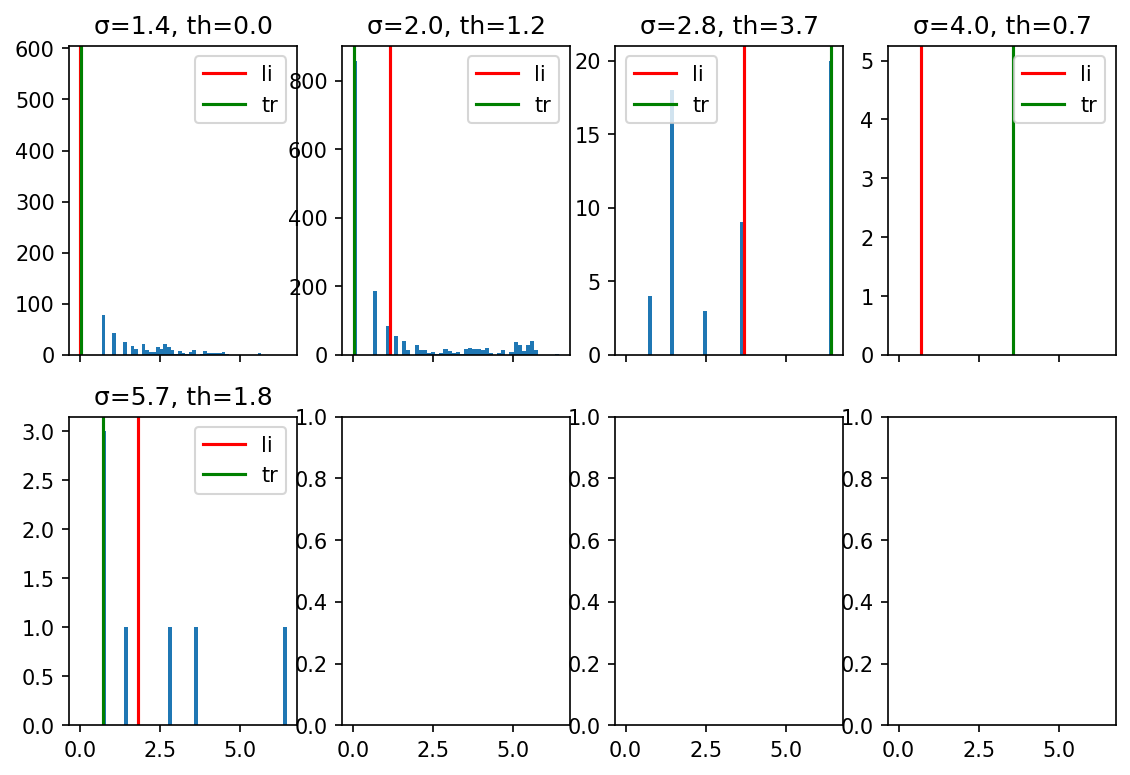

In [186]:
fig, axs = plt.subplots(2,4, figsize=(9,6), sharex=True)
occ_threshs = {}

for ax, sigma in zip(np.ravel(axs), sigmas):
    v_occ = occ_acc[sigma]
    th = threshold_li(v_occ)
    th_tr = threshold_triangle(v_occ)
    occ_threshs[sigma] = th
    ax.set_title(f'σ={sigma :0.1f}, th={th:0.1f}')
    ax.hist(v_occ, 50)
    ax.axvline(th, color='red', label='li')
    ax.axvline(th_tr, color='green', label='tr')
    ax.legend()
    

Проблема, однако, в том, что если я просто выкину узлы с низкой встречаемостью, то многие пути могут оказаться разрезанными, и я не смогу больше из всех конечных точек дойти до сомы.

Как вариант, можно выкидывать узлы с низкой встречаемостью, только если у них нет дочерних узлов (т.е. это листья графа). Но тогда это придется делать в несколько итераций. 
Либо можно убирать, если эта ветка нигде не ветвится дальше, но это сложнее отслеживать. 

In [187]:
np.log(2)

0.6931471805599453

In [192]:
def filter_fn_(G, n):
    ni = G.nodes[n]
    #is_high = ni['occurence'] > max(0, occ_threshs[ni['sigma_mask']])
    is_high = ni['occurence'] > 0 # very permissive, but some branches are valid and only occur once
    not_tip = len(list(G.successors(n)))
    return is_high and not_tip

In [193]:
gx_all_occ = gx_all

for i in tqdm(range(10)):
    good_nodes = (node for node in gx_all_occ if filter_fn_(gx_all_occ, node))
    gx_all_occ = gx_all_occ.subgraph(good_nodes)

  0%|          | 0/10 [00:00<?, ?it/s]

# Визуализация

In [190]:
import visualization as vis

In [316]:
VERBOSE=True

In [191]:
if VERBOSE:
    w =  napari.view_image(final_image, ndisplay=3, opacity=0.5)
#     w.add_image(sigma_mask, colormap='turbo', blending='additive', visible=False)
    vis.view_graph_as_colored_image(gx_all, final_image.shape, w);
    napari.run()

In [194]:
if VERBOSE:
    w =  napari.view_image(final_image, ndisplay=3, opacity=0.5)
    w.add_image(sigma_mask, colormap='turbo', blending='additive', visible=False)
    vis.view_graph_as_colored_image(gx_all_occ, final_image.shape, w);
    napari.run()
#     w.screenshot(os.path.join(output_dir, '{}_graph.png'.format(filename)))
#     w.close()

In [291]:
_ = 1

In [292]:
# if OUT:
#     w.screenshot(os.path.join(output_dir, '{}_graph.png'.format(filename)))

# Сохранение

In [234]:
import pickle

In [143]:
filename

'4wk-both8-grn-raw.pic'

In [151]:
if OUT:
    pickle_name = os.path.join(output_dir, str(filename) + '-sequential_graph.pickle')
    %time pickle.dump(gx_all_occ.copy(), open(pickle_name, 'wb'),)

CPU times: user 326 ms, sys: 6.93 ms, total: 332 ms
Wall time: 332 ms


In [152]:
# %time thin_graph2 = pickle.load(open(pickle_name, 'rb'))

In [ ]:
# w =  napari.view_image(final_image, ndisplay=3, opacity=0.5)
# vis.view_graph_as_colored_image(thin_graph2, final_image.shape, w);

In [ ]:
# tup2str = lambda x: ','.join(list(map(str, x)))
# str2tup = lambda x: tuple(map(int, x.split(',')))

In [ ]:
# with open('graph_3wk-both1-grn-raw.pic.pickle') as fd:
#     load_graph = pickle.load(fd)


In [ ]:
# nx.write_gml(gx_all_occ.copy(), 
#              'gx_all_{}.gml.gz'.format(os.path.basename(filename)), 
#              stringizer=tup2str)

In [ ]:
# loaded_graph = nx.read_gml('gx_all_{}.gml.gz'.format(os.path.basename(filename)), destringizer=str2tup)